<a href="https://colab.research.google.com/github/sanjanabayya30/Proj/blob/main/PJSSP%2BRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


🔧 Job-Machine-Time Assignments:
 Job ID  Operation  Machine  Start  End  Current Makespan  Contributes to Makespan
      0          0        0      0   29                29                    False
      2          0        2      0    9                29                    False
      1          0        1      0   78                78                    False
      2          1        3      0   75                78                    False
      4          0        4      0   49                78                    False
      1          1        2      9   99                99                    False
      4          1        0     29   98                99                    False
      2          2        3     75  114               114                    False
      0          1        1     78  121               121                    False
      1          2        0     98  183               183                    False
      0          2        2     99  190               

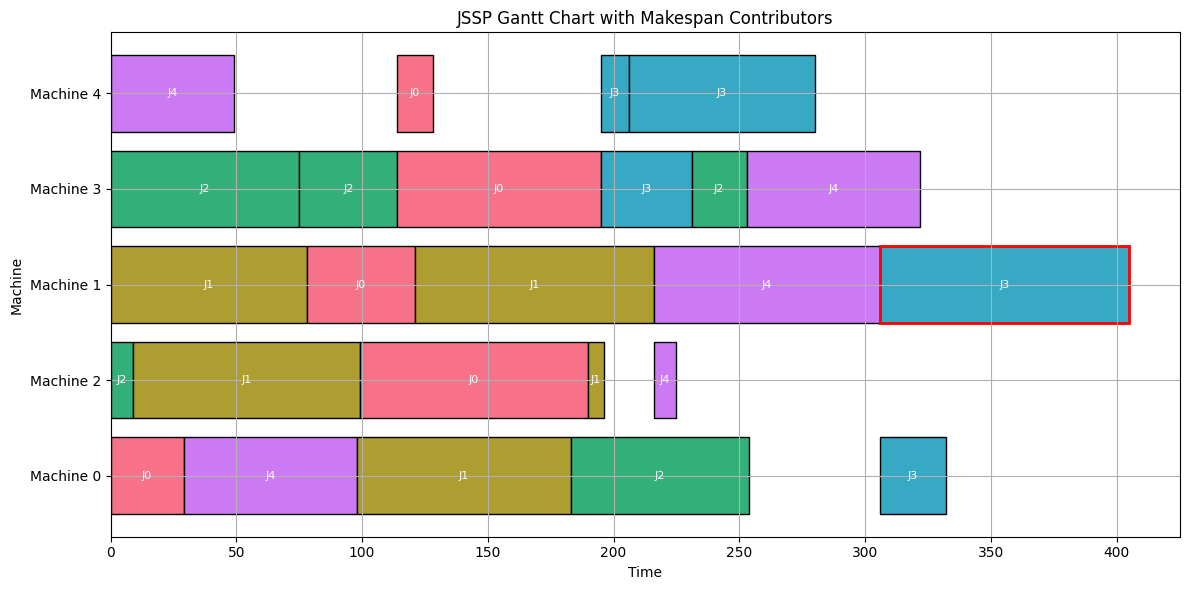

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import defaultdict
import seaborn as sns
import time

# Ensure repeatability
random.seed(42)
np.random.seed(42)

# Load the dataset (JSSP: only one machine per operation)
df = pd.read_csv("/content/FT20_Dataset.csv")
df["Machine"] = df["Machine"].apply(lambda x: int(x[1:]))

# Basic parameters
num_jobs = df["Job ID"].nunique()
num_machines = df["Machine"].nunique()
operations_per_job = df.groupby("Job ID")["Operation"].max().iloc[0] + 1

# Job operation mapping (only one machine per op)
job_operations = defaultdict(list)
for _, row in df.iterrows():
    job_operations[int(row["Job ID"])].append((int(row["Operation"]), int(row["Machine"]), int(row["Processing Time"])))
for job in job_operations:
    job_operations[job].sort(key=lambda x: x[0])

# Q-learning setup
alpha = 0.1
gamma = 0.9
epsilon = 0.3
epsilon_decay = 0.995
min_epsilon = 0.05
episodes = 5000
Q = defaultdict(float)

initial_makespan = None
best_makespan = float("inf")
best_schedule = []
evaluation_times = []

# Helpers
def get_feasible_actions(job_progress, machine_status, t):
    actions = []
    for job in range(num_jobs):
        if job_progress[job] < operations_per_job:
            op_num = job_progress[job]
            _, m, _ = job_operations[job][op_num]
            if machine_status[m] <= t:
                actions.append((job, m))
    return actions

# Simulation
def simulate(train=False):
    job_progress = [0] * num_jobs
    machine_status = [0] * (num_machines + 1)
    time = 0
    schedule = []
    total_idle = 0

    while any(p < operations_per_job for p in job_progress):
        feasible = get_feasible_actions(job_progress, machine_status, time)

        if not feasible:
            time += 1
            total_idle += 1
            continue

        state = (tuple(job_progress), tuple(machine_status))

        if train and random.random() < epsilon:
            job, m = random.choice(feasible)
        else:
            q_vals = [(Q[(state, job)], job, m) for job, m in feasible]
            _, job, m = max(q_vals, key=lambda x: x[0])

        op_num, m, pt = job_operations[job][job_progress[job]]
        start = max(machine_status[m], time)
        end = start + pt

        if train:
            next_job_progress = job_progress.copy()
            next_job_progress[job] += 1
            next_machine_status = machine_status.copy()
            next_machine_status[m] = end
            next_state = (tuple(next_job_progress), tuple(next_machine_status))

            reward = -pt
            max_future = max(
                Q[(next_state, j)] for j in range(num_jobs)
                if next_job_progress[j] < operations_per_job
            ) if any(next_job_progress[j] < operations_per_job for j in range(num_jobs)) else 0

            Q[(state, job)] += alpha * (reward + gamma * max_future - Q[(state, job)])

        job_progress[job] += 1
        machine_status[m] = end
        schedule.append((job, op_num, m, start, end))

    makespan = max(e for *_, e in schedule)
    return schedule, makespan, total_idle

# Training
for ep in range(episodes):
    start_time = time.time()
    sched, mkspan, _ = simulate(train=True)
    evaluation_times.append(time.time() - start_time)
    if ep == 0:
        initial_makespan = mkspan
    if mkspan < best_makespan:
        best_makespan = mkspan
        best_schedule = sched
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

# Evaluation
schedule_df = pd.DataFrame(best_schedule, columns=["Job ID", "Operation", "Machine", "Start", "End"])
schedule_df.sort_values(by="Start", inplace=True)
schedule_df["Current Makespan"] = schedule_df["End"].cummax()
schedule_df["Contributes to Makespan"] = schedule_df["End"] == best_makespan

used_time = schedule_df["End"].sub(schedule_df["Start"]).sum()
idle_machine_time = num_machines * best_makespan - used_time

avg_gap = (initial_makespan - best_makespan) / initial_makespan if initial_makespan else 0
avg_eval_time = np.mean(evaluation_times) if evaluation_times else 0

print("\n\U0001F527 Job-Machine-Time Assignments:")
print(schedule_df.to_string(index=False))
print(f"\n\U0001F680 Initial Random Makespan: {initial_makespan}")
print(f"\U0001F4CA Total Optimized Makespan: {best_makespan}")
print(f"\U0001F4C9 Makespan Reduced By: {initial_makespan - best_makespan} time units")
print(f"\U0001F6E0 Idle Machine Time Units: {idle_machine_time}")
print(f"\U0001F39E Average Gap: {avg_gap:.4f}")
print(f"\U0001F550 Average Evaluation Time: {avg_eval_time:.4f} seconds")

# Gantt Chart
plt.figure(figsize=(12, 6))
colors = sns.color_palette("husl", num_jobs)
for _, row in schedule_df.iterrows():
    color = colors[row["Job ID"]]
    edge = 'red' if row["Contributes to Makespan"] else 'black'
    lw = 2 if row["Contributes to Makespan"] else 1
    plt.barh(y=f"Machine {row['Machine']}", width=row["End"] - row["Start"],
             left=row["Start"], color=color, edgecolor=edge, linewidth=lw)
    plt.text(x=row["Start"] + (row["End"] - row["Start"]) / 2,
             y=f"Machine {row['Machine']}",
             s=f"J{row['Job ID']}",
             va='center', ha='center', color='white', fontsize=8)
plt.title("JSSP Gantt Chart with Makespan Contributors")
plt.xlabel("Time")
plt.ylabel("Machine")
plt.grid(True)
plt.tight_layout()
plt.show()


🔧 Job-Machine-Time Assignments:
 Job ID  Operation  Machine  Start  End  Current Makespan  Contributes to Makespan
      2          0        2      0    9                 9                    False
      3          0        3      0   36                36                    False
      3          1        4      0   11                36                    False
      0          0        0      0   29                36                    False
      0          1        1      0   43                43                    False
      0          2        2      9  100               100                    False
      3          2        4     11   85               100                    False
      0          3        3     36  117               117                    False
      1          0        1     43  121               121                    False
      0          4        4     85   99               121                    False
      4          0        4     99  148               

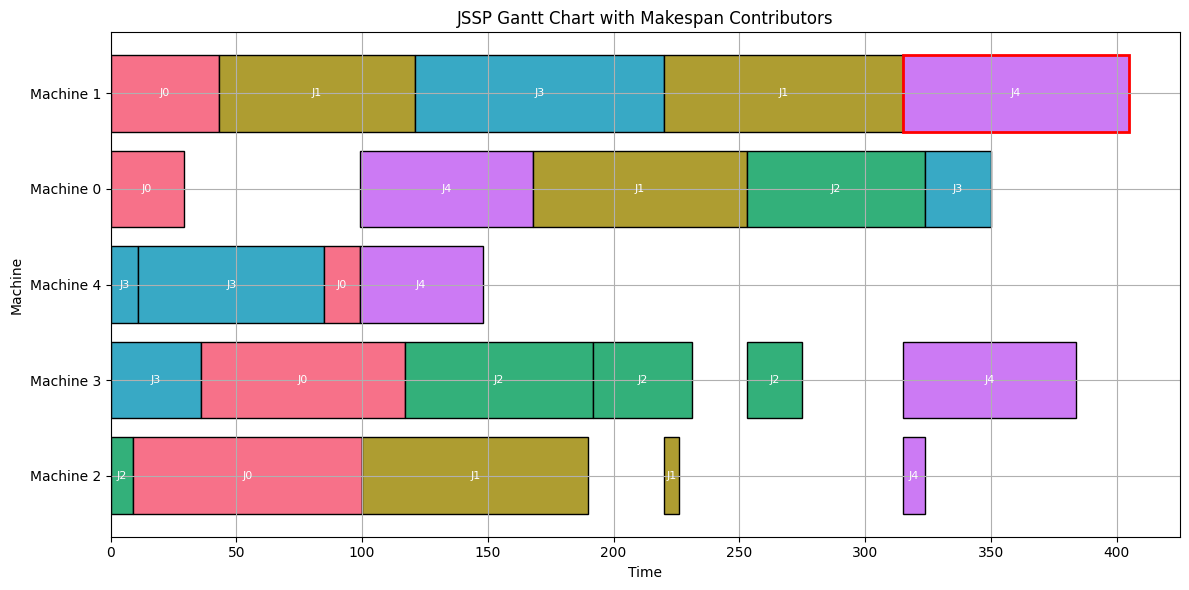

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import defaultdict
import seaborn as sns
import time

# Ensure repeatability
random.seed(42)
np.random.seed(42)

# Load the dataset (JSSP: only one machine per operation)
df = pd.read_csv("/content/FT20_Dataset.csv")
df["Machine"] = df["Machine"].apply(lambda x: int(x[1:]))

# Basic parameters
num_jobs = df["Job ID"].nunique()
num_machines = df["Machine"].nunique()
operations_per_job = df.groupby("Job ID")["Operation"].max().iloc[0] + 1

# Job operation mapping (only one machine per op)
job_operations = defaultdict(list)
for _, row in df.iterrows():
    job_operations[int(row["Job ID"])].append((int(row["Operation"]), int(row["Machine"]), int(row["Processing Time"])))
for job in job_operations:
    job_operations[job].sort(key=lambda x: x[0])

# Q-learning setup
alpha = 0.1
gamma = 0.9
epsilon = 0.3
epsilon_decay = 0.995
min_epsilon = 0.05
episodes = 5000
Q = defaultdict(float)

initial_makespan = None
best_makespan = float("inf")
best_schedule = []
evaluation_times = []

# Helpers
def get_feasible_actions(job_progress, machine_status, t):
    actions = []
    for job in range(num_jobs):
        if job_progress[job] < operations_per_job:
            op_num = job_progress[job]
            _, m, _ = job_operations[job][op_num]
            if machine_status[m] <= t:
                actions.append((job, m))
    return actions

# Simulation
def simulate(train=False):
    job_progress = [0] * num_jobs
    machine_status = [0] * (num_machines + 1)
    time = 0
    schedule = []
    total_idle = 0

    while any(p < operations_per_job for p in job_progress):
        feasible = get_feasible_actions(job_progress, machine_status, time)

        if not feasible:
            time += 1
            total_idle += 1
            continue

        state = (tuple(job_progress), tuple(machine_status))

        if train and random.random() < epsilon:
            job, m = random.choice(feasible)
        else:
            q_vals = [(Q[(state, job)], job, m) for job, m in feasible]
            _, job, m = max(q_vals, key=lambda x: x[0], default=(0, feasible[0][0], feasible[0][1]))

        op_num, m, pt = job_operations[job][job_progress[job]]
        start = max(machine_status[m], time)
        end = start + pt

        if train:
            next_job_progress = job_progress.copy()
            next_job_progress[job] += 1
            next_machine_status = machine_status.copy()
            next_machine_status[m] = end
            next_state = (tuple(next_job_progress), tuple(next_machine_status))

            reward = -pt
            max_future = max(
                Q[(next_state, j)] for j in range(num_jobs)
                if next_job_progress[j] < operations_per_job
            ) if any(next_job_progress[j] < operations_per_job for j in range(num_jobs)) else 0

            Q[(state, job)] += alpha * (reward + gamma * max_future - Q[(state, job)])

        job_progress[job] += 1
        machine_status[m] = end
        schedule.append((job, op_num, m, start, end))

    makespan = max(e for *_, e in schedule)
    return schedule, makespan, total_idle

# Generate initial random makespan (purely random policy)
def get_random_initial_makespan():
    random.seed(42)  # Reset seed for consistency
    job_progress = [0] * num_jobs
    machine_status = [0] * (num_machines + 1)
    time = 0
    schedule = []
    total_idle = 0

    while any(p < operations_per_job for p in job_progress):
        feasible = get_feasible_actions(job_progress, machine_status, time)

        if not feasible:
            time += 1
            total_idle += 1
            continue

        job, m = random.choice(feasible)
        op_num, m, pt = job_operations[job][job_progress[job]]
        start = max(machine_status[m], time)
        end = start + pt

        job_progress[job] += 1
        machine_status[m] = end
        schedule.append((job, op_num, m, start, end))

    makespan = max(e for *_, e in schedule)
    return makespan

# Compute initial random makespan before training
initial_makespan = get_random_initial_makespan()

# Training
for ep in range(episodes):
    start_time = time.time()
    sched, mkspan, _ = simulate(train=True)
    evaluation_times.append(time.time() - start_time)
    if mkspan < best_makespan:
        best_makespan = mkspan
        best_schedule = sched
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

# Evaluation
schedule_df = pd.DataFrame(best_schedule, columns=["Job ID", "Operation", "Machine", "Start", "End"])
schedule_df.sort_values(by="Start", inplace=True)
schedule_df["Current Makespan"] = schedule_df["End"].cummax()
schedule_df["Contributes to Makespan"] = schedule_df["End"] == best_makespan

used_time = schedule_df["End"].sub(schedule_df["Start"]).sum()
idle_machine_time = num_machines * best_makespan - used_time

# Modified gap calculation to ensure non-negative
makespan_reduction = max(0, initial_makespan - best_makespan)  # Ensure non-negative reduction
avg_gap = makespan_reduction / initial_makespan if initial_makespan else 0

avg_eval_time = np.mean(evaluation_times) if evaluation_times else 0

print("\n\U0001F527 Job-Machine-Time Assignments:")
print(schedule_df.to_string(index=False))
print(f"\n\U0001F680 Initial Random Makespan: {initial_makespan}")
print(f"\U0001F4CA Total Optimized Makespan: {best_makespan}")
print(f"\U0001F4C9 Makespan Reduced By: {makespan_reduction} time units")
print(f"\U0001F6E0 Idle Machine Time Units: {idle_machine_time}")
print(f"\U0001F39E Average Gap: {avg_gap:.4f}")
print(f"\U0001F550 Average Evaluation Time: {avg_eval_time:.4f} seconds")

# Gantt Chart
plt.figure(figsize=(12, 6))
colors = sns.color_palette("husl", num_jobs)
for _, row in schedule_df.iterrows():
    color = colors[row["Job ID"]]
    edge = 'red' if row["Contributes to Makespan"] else 'black'
    lw = 2 if row["Contributes to Makespan"] else 1
    plt.barh(y=f"Machine {row['Machine']}", width=row["End"] - row["Start"],
             left=row["Start"], color=color, edgecolor=edge, linewidth=lw)
    plt.text(x=row["Start"] + (row["End"] - row["Start"]) / 2,
             y=f"Machine {row['Machine']}",
             s=f"J{row['Job ID']}",
             va='center', ha='center', color='white', fontsize=8)
plt.title("JSSP Gantt Chart with Makespan Contributors")
plt.xlabel("Time")
plt.ylabel("Machine")
plt.grid(True)
plt.tight_layout()
plt.show()